### Дерево решений
По материалам [открытого курса машинного обучения (Yury Kashnitsky)](https://habr.com/ru/company/ods/blog/322534/) и [лекций Евгения Соколова](https://datasciencecourse.ru/)

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import math
import pandas as pd
plt.style.use("dark_background")

from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.tree import export_graphviz
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score

- $\textbf {X} - $ пространство объектов;
- $\textbf {Y} - $ пространство ответов;
- $ x = (x^j)_{j=1}^d - $ признаковое описание объекта $(x \in \mathbf{X})$;
- $X_m = (x_i, y_i)_{i=1}^m -$ обучающая выборка 
    $(x \in \mathbf{X}, y \in \mathbf{Y})$;
- $a: \textbf {X} \to \textbf {Y} -$ алгоритм (модель) - дерево решений;
- $Q(a, X)$ - функционал ошибки алгоритма $a$ на выборке $X_m$;
- Обучение: $a(x)=argmin \; Q(a, X_m;)$
- $\mathbf K$ - количество классов.

#### Алгоритм разбиения
- Пусть в вершине $m$ оказалась выборка $X_m$, а  $Y_m - $ соответствующее этой выборке пространство ответов
- $Q(X_m, j, t) -$ критерий ошибки условия $[x^j \leq t]$ 
- $Q(X_m, j, t) \to \underset{j,t}{min}$
- $X_l = {x \in X_m: [X^j \leq t]} \\
  X_r = {x \in X_m: [X^j > t]},\\ 
  \text{где } X_m = X_l \cup X_r: X_l \cap X_r = \emptyset$

#### Ответ в листе
- Регрессия: $a_m = \frac{1}{|X_m|} \sum\limits_{i=1}^{m} y_i$
- Классификация: $a_m = \underset{k}{argmax} \sum\limits_{i=1}^{m} [y_i = y_k], \; 
    k=\overline{1, \mathbf{K}}$
- Вероятности классов: $a_{mk}=\frac{1}{|X_m|}\sum\limits_{i=1}^{m} [y_i = y_k], \; 
    k=\overline{1, \mathbf{K}}$    

#### Критерий информативности разбиения
$$Q(X_m, j, t) = \frac{|X_l|}{|X_m|}H(X_l) + \frac{|X_r|}{|X_m|}H(X_r) \notag$$
##### Регрессия. MSE 
$\overline{y}(X)= \frac{1}{|X|}\sum\limits_{i \in X}y_i\\
H(X) = \frac{1}{|X|}\sum\limits_{i \in X}(y_i - \overline{y}(X))^2$
##### Классификация
$p_k = \frac{1}{|X|}\sum\limits_{i \in X}[y_i=k]\;-$ доля объяектов класса $k$ в выборке $X$
##### Классификация. ***Критерий Джини***
$H(X)=\sum\limits_{k=1}^{K}p_k(1-p_k)$ 
- вероятность ошибки классификатора, который выдает ответы пропорционально $p_k$

##### Классификация. ***Энтропия Шеннона***
***Энтропия Шеннона*** определяется для системы с $N$ возможными состояниями:
$$S = -\frac{1}{n}\sum\limits_{i=1}^{n}p_i log_2 p_i, \notag$$
где $p_i - $ вероятности нахождения сисмтемы в $i$-ом состоянии.

- мера отличия распределения классов от вырожденного

***Прирост информации (Information gain)***
$$IG(Q)=S_0 - \sum\limits_{i=1}^{q}\frac{N_i}{N}S_i, \notag$$

где $q$ - число групп после разбиения, $N_i$ - число элементов выборки, у которых признак $Q$ имеет $i$-ое значение.

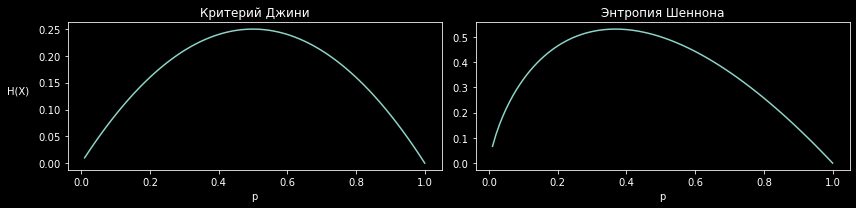

In [12]:
# Критерий Джини
def GC(p):
    return p*(1-p)

# Критерий Шеннона
def S(p):
    return -p*math.log(p, 2)

x = np.arange(0.01, 1.01, 0.01)

fig, ax = plt.subplots(1, 2, figsize=(12, 3))
ax[0].plot(x, GC(x))
ax[0].set_xlabel('p')
ax[0].set_ylabel('H(X)', rotation=0, labelpad=20)
ax[0].set_title('Критерий Джини')

ax[1].plot(x, [S(p) for p in x])
ax[1].set_xlabel('p')
ax[1].set_title('Энтропия Шеннона')

plt.tight_layout()
plt.show()

In [13]:
'''Рассмотрим игрушечный пример'''

# энтропия Шеннона
def get_S(arr):

    S = 0
    for k in np.unique(arr):

        p = arr[arr == k].size/arr.size
        S += p*math.log(p, 2)

    return -S

# Прирост информации (information gain)
def get_IG(left, right):
    
    S = get_S(np.r_[left,right])
    l = np.r_[left,right]

    for arr in (left, right):

        p = arr.size/l.size
        S -= p*get_S(arr)
    
    return S

# генерируем j-ый признак
X = np.array([1] + [0]*4 + [1]*4 + [0]*4 + [1]*6 + [0])
print('j-ый признак:', X)

# список значений прироста информации по каждому разбиению
igs = []

for i in range(1, len(X)):
    left, right = X[:i], X[i:]
    igs.append(get_IG(left, right))

print('Индекс вершины разбиения множества:', np.argmax(igs))
print('Значение прироста информации у данной вершины:', round(max(igs), 2))

j-ый признак: [1 0 0 0 0 1 1 1 1 0 0 0 0 1 1 1 1 1 1 0]
Индекс вершины разбиения множества: 12
Значение прироста информации у данной вершины: 0.16


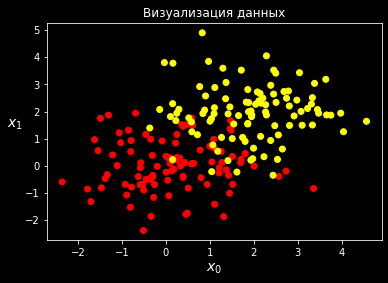

In [14]:
'''Игрушечный пример'''

# Два класса будут сгенерированы из двух нормальных распределений с разными средними
np.random.seed(32)

data = np.random.normal(size=(100, 2), loc=0)
data = np.r_[data, np.random.normal(size=(100, 2), loc=2)]
labs = np.r_[np.zeros(100), np.ones(100)]

plt.scatter(data[:, 0], data[:, 1], c=labs, cmap='autumn')
plt.xlabel('$x_0$', fontsize=14)
plt.ylabel('$x_1$', fontsize=14, rotation=0, labelpad=10)
plt.title('Визуализация данных')
plt.show()

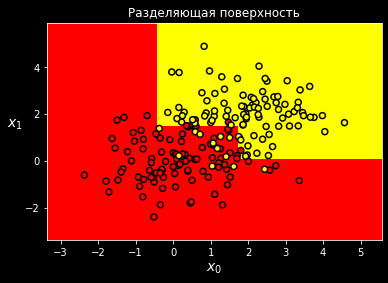

In [15]:
def get_greed(data):
    x_min, x_max = data[:, 0].min() - 1, data[:, 0].max() + 1
    y_min, y_max = data[:, 1].min() - 1, data[:, 1].max() + 1
    return np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))

clf_tree = DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=32)
clf_tree.fit(data, labs)

xx, yy = get_greed(data)
data[:, 0].min(), xx[0, 0]

predicted = clf_tree.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
plt.pcolormesh(xx, yy, predicted, cmap='autumn')
plt.scatter(data[:, 0], data[:, 1], c=labs, cmap='autumn', edgecolor='black', linewidth=1.5)
plt.xlabel('$x_0$', fontsize=14)
plt.ylabel('$x_1$', fontsize=14, rotation=0, labelpad=10)
plt.title('Разделяющая поверхность')
plt.show()

In [16]:
# Построим дерево

export_graphviz(clf_tree, feature_names=[0, 1], out_file='../media/tree.dot', filled=True)

!dot -Tpng '../media/tree.dot' -o '../media/tree.png'

![title](../media/tree.png)

### Дерево решений в задаче регрессии
#### Критерий качества: дисперсия вокруг среднего (MSE)
$\overline{y}(X)= \frac{1}{|X|}\sum\limits_{i \in X}y_i \\
H(X) = \frac{1}{|X|}\sum\limits_{i \in X}(y_i - \overline{y}(X))^2$

Сгенерируем данные, распределенные вокруг функции $f(x) = e^{-x ^ 2} + 1.5 * e^{-(x - 2) ^ 2}$ c некоторым шумом, обучим на них дерево решений и изобразим, какие прогнозы делает дерево.


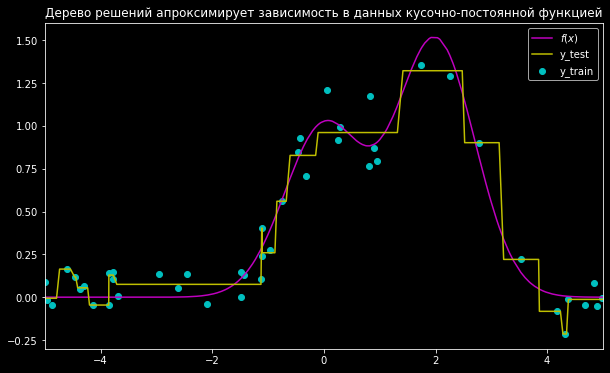

In [17]:
train = 150
test = 1000
noise = 0.1

def f(x):
#     x = x.ravel()
    return np.exp(-x ** 2) + 1.5 * np.exp(-(x - 2) ** 2)

def generate(n_samples, noise):
    np.random.seed(32)
    X = np.random.randn(n_samples)*10-5
    X = np.sort(X).ravel()
    y = f(X) + np.random.normal(loc=0, scale=noise, size=n_samples)
    X = X.reshape((n_samples, -1))
    return X, y

X_train, y_train = generate(n_samples=train, noise=noise)
X_test, y_test = generate(n_samples=test, noise=noise)

reg_tree = DecisionTreeRegressor(max_depth=5, random_state=17)
reg_tree.fit(X_train, y_train)
reg_tree_pred = reg_tree.predict(X_test)

plt.figure(figsize=(10, 6))
plt.plot(X_test, f(X_test), 'm', label='$f(x)$')
plt.scatter(X_train, y_train, color='c', label='y_train')
plt.plot(X_test, reg_tree_pred, c='y', label='y_test')
plt.xlim([-5, 5])
ttl = 'Дерево решений апроксимирует зависимость в данных кусочно-постоянной функцией'
plt.title(ttl)
plt.legend()
plt.show()

##### KNN vs  Decision Tree

In [38]:
PATH_DIR = '../../bases/'
FILE_NAME = 'telecom_churn_data.csv'

PATH_FILE = os.path.join(PATH_DIR, FILE_NAME)
print(os.path.isfile(PATH_FILE))

True


In [36]:
df = pd.read_csv(PATH_FILE)

df['international plan'] = pd.factorize(df['international plan'])[0]
df['voice mail plan'] = pd.factorize(df['voice mail plan'])[0]
df['churn'] = df['churn'].astype('int')
states = df['state']
y = df['churn']
df.drop(['state', 'churn', 'phone number'], axis=1, inplace=True)
df.head()

,account length,area code,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls
0,128,415,0,0,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1
1,107,415,0,0,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1
2,137,415,0,1,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0
3,84,408,1,1,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2
4,75,415,1,1,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3


In [39]:
X_train, X_holdout, y_train, y_holdout = train_test_split(df.values, y, test_size=0.3,
                                                         random_state=32)

tree = DecisionTreeClassifier(max_depth=5, random_state=32)
knn = KNeighborsClassifier(n_neighbors=10)

tree.fit(X_train, y_train)
knn.fit(X_train, y_train)

tree_pred = tree.predict(X_holdout)
tree_score = accuracy_score(y_holdout, tree_pred)
print(f"tree's accuracy: {tree_score}")

knn_pred = knn.predict(X_holdout)
knn_score = accuracy_score(y_holdout, knn_pred)
print(f"knn's accuracy: {knn_score}")

tree's accuracy: 0.939
knn's accuracy: 0.885


In [40]:
%%time
# настроим данные на кросс-валидации по двум параметрам: max_depth, max_features.
tree_params = {'max_depth': range(1, 11), 'max_features': range(4, 19)}
tree_grid = GridSearchCV(tree, tree_params, cv=5, n_jobs=-1, verbose=True)
tree_grid.fit(X_train, y_train)

Fitting 5 folds for each of 150 candidates, totalling 750 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 174 tasks      | elapsed:    5.7s


CPU times: user 901 ms, sys: 90.8 ms, total: 992 ms
Wall time: 14.7 s


[Parallel(n_jobs=-1)]: Done 750 out of 750 | elapsed:   14.7s finished


GridSearchCV(cv=5,
             estimator=DecisionTreeClassifier(max_depth=5, random_state=32),
             n_jobs=-1,
             param_grid={'max_depth': range(1, 11),
                         'max_features': range(4, 19)},
             verbose=True)

In [41]:
tree_grid.best_params_

{'max_depth': 8, 'max_features': 8}

In [42]:
accuracy_score(y_holdout, tree_grid.predict(X_holdout))

0.936

In [43]:
%%time
knn_pipe = Pipeline(steps=[('scaler', StandardScaler()), ('knn', KNeighborsClassifier(n_jobs=-1))])
knn_params = {'knn__n_neighbors': range(1, 10)}
knn_grid = GridSearchCV(knn_pipe, knn_params, cv=5, n_jobs=-1, verbose=True)
knn_grid.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 9 candidates, totalling 45 fits
CPU times: user 228 ms, sys: 18 ms, total: 246 ms
Wall time: 5.61 s


[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    5.6s finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('knn',
                                        KNeighborsClassifier(n_jobs=-1))]),
             n_jobs=-1, param_grid={'knn__n_neighbors': range(1, 10)},
             verbose=True)

In [44]:
knn_grid.best_params_, knn_grid.best_score_

({'knn__n_neighbors': 5}, 0.8915596768709048)

In [45]:
accuracy_score(y_holdout, knn_grid.predict(X_holdout))

0.883

#### Случайный лес

In [46]:
%%time
forest = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=32)
# forest_params = {'max_depth': range(1, 11), 'max_features': range(4, 19)}
forest_params = {'max_depth': range(5, 10), 'max_features': range(10, 15)}
forest_grid = GridSearchCV(forest, forest_params, cv=5, n_jobs=-1, verbose=True)
forest_grid.fit(X_train, y_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   41.1s
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed:  2.2min finished


CPU times: user 1.66 s, sys: 103 ms, total: 1.76 s
Wall time: 2min 12s


GridSearchCV(cv=5, estimator=RandomForestClassifier(n_jobs=-1, random_state=32),
             n_jobs=-1,
             param_grid={'max_depth': range(5, 10),
                         'max_features': range(10, 15)},
             verbose=True)

In [48]:
forest_grid.best_params_, forest_grid.best_score_

({'max_depth': 8, 'max_features': 10}, 0.9515710727775686)

In [49]:
accuracy_score(y_holdout, forest_grid.predict(X_holdout))

0.952

#### Сложный случай для деревьев решений

In [50]:
def form_linearly_separable_data(n=500, x1_min=0, x1_max=30, x2_min=0, x2_max=30):
    
    data, target = [], []
    for i in range(n):

        x1, x2 = np.random.randint(x1_min, x1_max), np.random.randint(x2_min, x2_max)
        
        if np.abs(x1-x2) > 0.5:
            data.append([x1, x2])
            target.append(np.sign(x1-x2))
    
    return np.array(data), np.array(target)
    
X, y = form_linearly_separable_data()

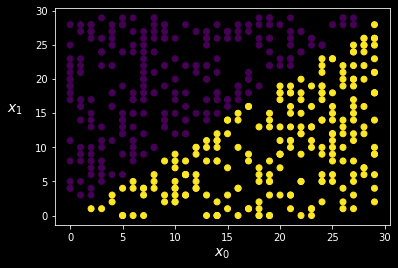

In [51]:
plt.scatter(X[:, 0], X[:, 1], c=y)
plt.xlabel('$x_0$', fontsize=14)
plt.ylabel('$x_1$', rotation=0, labelpad=20, fontsize=14)
plt.show()

In [52]:
def get_greed(data):
    x_min, x_max = data[:, 0].min() - 1, data[:, 0].max() + 1
    y_min, y_max = data[:, 1].min() - 1, data[:, 1].max() + 1
    return np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))

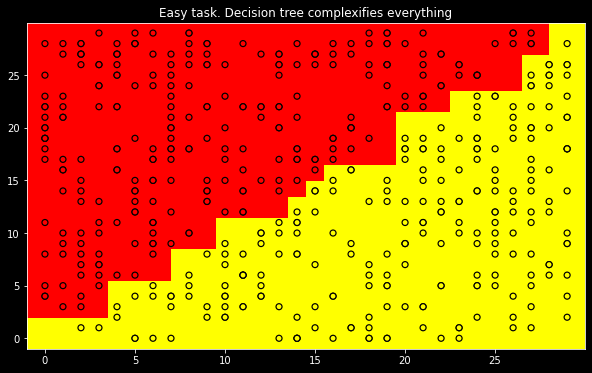

In [53]:
tree = DecisionTreeClassifier(random_state=32).fit(X, y)
xx, yy = get_greed(X)
predicted = tree.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
plt.figure(figsize=(10, 6))
plt.pcolormesh(xx, yy, predicted, cmap='autumn')
plt.scatter(X[:, 0], X[:, 1], c=y, edgecolor='black', linewidth=1.2, cmap='autumn')
plt.title('Easy task. Decision tree complexifies everything')
plt.show()

In [54]:
export_graphviz(tree, feature_names=['x1', 'x2'], out_file='../media/deep_tree.dot', filled=True)
!dot -Tpng '../media/deep_tree.dot' -o '../media/deep_tree.png'

![title](../media/deep_tree.png)

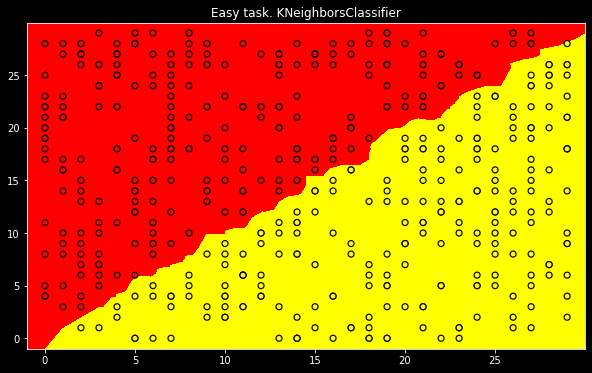

In [55]:
knn = KNeighborsClassifier().fit(X, y)
xx, yy = get_greed(X)
predicted = knn.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
plt.figure(figsize=(10, 6))
plt.pcolormesh(xx, yy, predicted, cmap='autumn')
plt.scatter(X[:, 0], X[:, 1], c=y, edgecolor='black', linewidth=1.2, cmap='autumn')
plt.title('Easy task. KNeighborsClassifier')
plt.show()

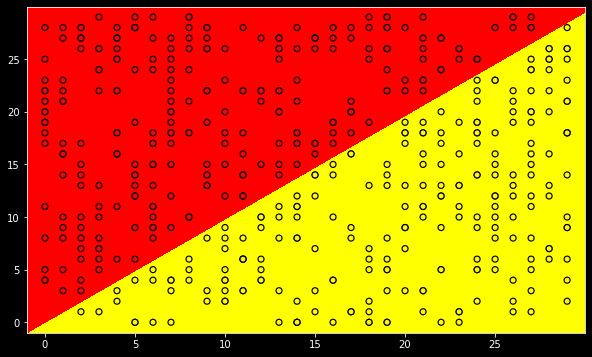

In [56]:
sgd = SGDClassifier().fit(X, y)
xx, yy = get_greed(X)
predicted = sgd.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
plt.figure(figsize=(10, 6))
plt.pcolormesh(xx, yy, predicted, cmap='autumn')
plt.scatter(X[:, 0], X[:, 1], c=y, edgecolor='black', linewidth=1.2, cmap='autumn')
plt.show()

#### Сложный случай для метода ближайших соседей

In [57]:
# генерация шумных данных с одним признаком, пропорциональному вектору ответов

def form_noisy_data(n_obj=1000, n_feat=100, random_seed=17):
    
    np.random.seed(random_seed)
    y = np.random.choice([-1, 1], size=n_obj)

    x1 = 0.3*y

    x_other = np.random.random(size=[n_obj, n_feat-1])

    return np.hstack([x1.reshape([n_obj, 1]), x_other]), y

X, y = form_noisy_data()
# train_test_split?
X_train, X_holdout, y_train, y_holdout = train_test_split(X, y, test_size=0.33, 
                                                       random_state=17)

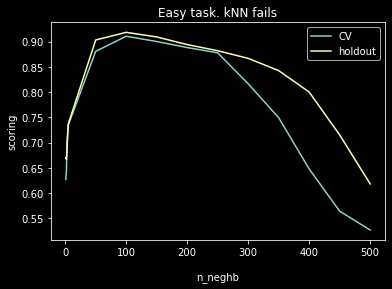

In [58]:
# Построение кривых валидации для KNN
cv_scores, holdout_scores = [], []

n_neighb = [1, 2, 3, 5] + list(range(50, 550, 50))

for k in n_neighb:

    knn = KNeighborsClassifier(n_neighbors=k)
    # scoring: If None, the estimator’s default scorer (if available) is used
    # knn: Return the mean accuracy on the given test data and labels
    cv_scores.append(np.mean(cross_val_score(knn, X_train, y_train, cv=5, scoring=None)))
    knn.fit(X_train, y_train)
    holdout_scores.append(accuracy_score(y_holdout, knn.predict(X_holdout)))
    
plt.plot(n_neighb, cv_scores, label='CV')
plt.plot(n_neighb, holdout_scores, label='holdout')
plt.title('Easy task. kNN fails')
plt.legend()
plt.xlabel('n_neghb', labelpad=14)
plt.ylabel('scoring')
plt.show()
    

In [59]:
# Обучение дерева
tree = DecisionTreeClassifier(random_state=17, max_depth=1)
tree_cv_score = np.mean(cross_val_score(tree, X_train, y_train, cv=5))
tree.fit(X_train, y_train)
tree_holdout_score = accuracy_score(y_holdout, tree.predict(X_holdout))
print(f'Decision tree. CV: {tree_cv_score}, holdout: {tree_holdout_score}')

Decision tree. CV: 1.0, holdout: 1.0
